In [192]:
# Till Wagner's python version:
#
# Reference: "How Model Complexity Influences Sea Ice Stability",
# T.J.W. Wagner & I. Eisenman, J Clim (2015)
#
# WE15_EBM_simple.m:
# This code describes the EBM as discussed in Sec. 2b of the article above,
# hereafter WE15. Here we use central difference spatial integration and
# time stepping with MATLAB's ode45.
#
# The code WE15_EBM_fast.m, on the other hand, uses a faster, but more
# complicated formulation of the diffusion operator and Implicit Euler time
# stepping.
#
# Parameters are as described in WE15, table 1. Note that we do not include
# ocean heat flux convergence or a seasonal cylce in the forcing
# (equivalent to S_1 = F_b = 0 in WE15). This code uses an ice albedo when
# T<0 (WE15 instead uses the condition E<0, which is appropriate for the
# inclusion of a seasonal cycle in ice thickness). In this code, we define
# T = Ts - Tm, where Ts is the surface temperature and Tm the melting point
# (WE15, by contrast, defines T = Ts).
#
# Till Wagner & Ian Eisenman, Mar 15
# tjwagner@ucsd.edu or eisenman@ucsd.edu
##-------------------------------------------------------------------------

## Import the required modules
import numpy as np
import matplotlib.colors as mcolors
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [193]:
## Model parameters (WE15, Table 1 and Section 2d) ------------------------
D = 0.6 # diffusivity for heat transport (W m^-2 K^-1)
A = 193 # OLR when T = 0 (W m^-2)
B = 2.1 # OLR temperature dependence (W m^-2 K^-1)
cw = 9.8 # ocean mixed layer heat capacity (W yr m^-2 K^-1)
S0 = 420 # insolation at equator (W m^-2)
S2 = 240 # insolation spatial dependence (W m^-2)
## co-albedo: 1 - albedo
a0 = 0.7 # ice-free co-albedo at equator
a2 = 0.1 # ice=free co-albedo spatial dependence
ai = 0.4 # co-albedo where there is sea ice
F = 0.0 # radiative forcing (W m^-2)
# -------------------------------------------------------------------------
n = 50 # grid resolution (number of points between equator and pole)
x = np.linspace(0,1,n)
dx = 1.0/(n-1)
S = S0-S2*x**2 # insolation [WE15 eq. (3) with S_1 = 0]
aw = a0-a2*x**2 # open water albedo
# ODE with spatial finite differencing-------------------------------------

## Define the function that evaluates the temperature at the next timestep
def odefunc(T,t):
    alpha = aw*(T>0)+ai*(T<0)
    C = alpha*S-A+F
    Tdot = np.zeros(x.shape)
    # solve c_wdT/dt = D(1-x^2)d^
    for i in range(1,n-1):
        # solve c_w dT/dt = D (1-x^2) d^2 T/dx^2 - 2 x D dT/dx + C - B T [cf. WE15 eq. (2)]
        Tdot[i]=(D/dx**2)*(1-x[i]**2)*(T[i+1]-2*T[i]+T[i-1])-(D*x[i]/dx)*(T[i+1]-T[i-1])
        # use central difference
        Tdot[0] = D*2*(T[1]-T[0])/dx**2
        Tdot[-1] = -D*2*x[-1]*(T[-1]-T[-2])/dx
    f = (Tdot+C-B*T)/cw
    return f

In [194]:
### Problem 1: Temperature distribution after 30 years without anthropogenic forcing
## Perform the run without anthropogenic forcing (i.e., F=0)
F = 0.0
T0 = 10*np.ones(x.shape)            # initial condition (constant temp. 10C everywhere)
time = np.linspace(0.0,30.,1000)    # time span in years (30.0) with 1000 timesteps
T = odeint(odefunc,T0,time)         # solve

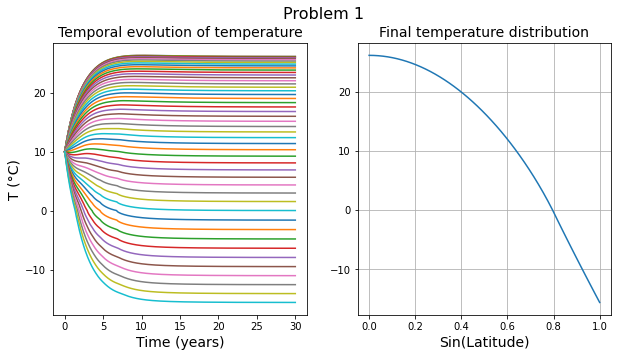

In [195]:
## Plotting
fs = 14

fig,ax = plt.subplots(1,2,figsize=(10,5),squeeze=True)
ax[0].plot(time,T)
ax[0].set_xlabel('Time (years)',fontsize=fs)
ax[0].set_ylabel('T (°C)',fontsize=fs)
ax[0].set_title('Temporal evolution of temperature',fontsize=14)

ax[1].plot(x,T[-1,:])
ax[1].set_xlabel('Sin(Latitude)',fontsize=fs)
ax[1].set_title('Final temperature distribution',fontsize=fs)
ax[1].grid()

fig.suptitle('Problem 1', fontsize=fs+2)
plt.savefig('problem/ex1_sol.png',dpi=300)

In [197]:
## determine temperature at the equator & pole & avg. temperature
print('T_eq: '+str(T[-1,0]))
print('T_pole: '+str(T[-1,-1]))
print('T_av: '+str(np.mean(T[-1,:])))

T_eq: 26.13010425975352
T_pole: -15.570865904477246
T_av: 12.380686173148451


In [198]:
### Problem 2: effect of anthropogenic forcing
## Perform the control run without anthropogenic forcing (i.e., F=0)
## Problem 2a)
T_control = T                         # rename result from (1) to T_control for consistency
forcings = [1.9,2.6,4.5,7.0,8.5]      # create a list with the IPCC forcings in W/m^2
T_warms = np.empty((len(forcings),len(x)))
dTs = np.empty((len(forcings),len(x)))

print(T_warms.shape)

for idx,f in enumerate(forcings):
    F = f
    t_warm = odeint(odefunc,T0,time)
    T_warms[idx] = t_warm[-1,:]
    dTs[idx]=t_warm[-1,:]-T_control[-1,:]

(5, 50)


1.9: 1.4901560646640724
2.6: 2.383064032329003
4.5: 3.821783655199843
7.0: 5.520041047265561
8.5: 6.697340079932767


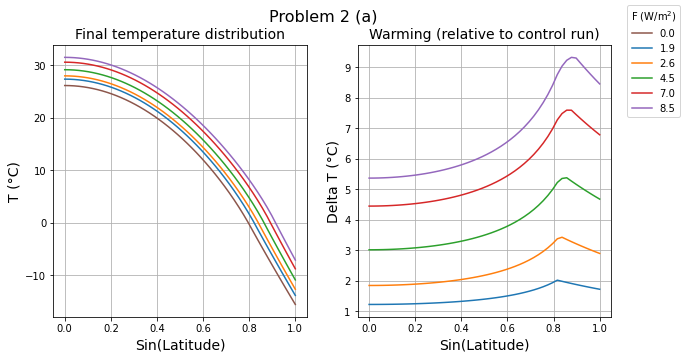

In [202]:
## Plotting
fig,ax = plt.subplots(1,2,figsize=(10,5))
for idx,val in enumerate(forcings):
    ax[0].plot(x,T_warms[idx])
    ax[1].plot(x,dTs[idx],label=str(val))
    
ax[0].plot(x,T_control[-1,:],label='0.0')
ax[0].set_xlabel('Sin(Latitude)',fontsize=fs)
ax[0].set_ylabel('T (°C)',fontsize=fs)
ax[0].grid()
ax[0].set_title('Final temperature distribution',fontsize=fs)
ax[1].set_xlabel('Sin(Latitude)',fontsize=fs)
ax[1].set_ylabel('Delta T (°C)',fontsize=fs)
ax[1].grid()
ax[1].set_title('Warming (relative to control run)',fontsize=fs)
fig.suptitle('Problem 2 (a)',fontsize=fs+2)
fig.legend(title='F (W/m$^2$)')

## calculating the mean warming for the different IPCC scenarios
for idx,val in enumerate(forcings):
    print(str(val)+': '+str(np.mean(dTs[idx])))
    
plt.savefig('problem/ex2a_sol.png',dpi=300)

In [203]:
## Problem 2b) where is warming most pronounced?
## find out where we have sea ice, i.e., where T<0
# define an array (ic = ice cover) that is assigned the value 1 if ice is present and 0 if no ice is present
ic = np.empty_like(T_warms)
x_ic = np.empty((len(forcings),2))
ic_control = np.empty_like(T_control[-1,:])

for idx,val in enumerate(T_control[-1,:]):
    if val>0: ic_control[idx]=1
    else: ic_control[idx]=0

for idx1,val1 in enumerate(T_warms):
    for idx2,val2 in enumerate(val1):
        if val2>0: ic[idx1][idx2] = 1
        else: ic[idx1][idx2] = 0
    
for idx,val in enumerate(T_warms):
    ic[idx] = ic[idx]-ic_control
    x_ic[idx,0]=np.min(np.ma.masked_where(ic[idx]==0, x))
    x_ic[idx,1]=np.max(np.ma.masked_where(ic[idx]==0, x))

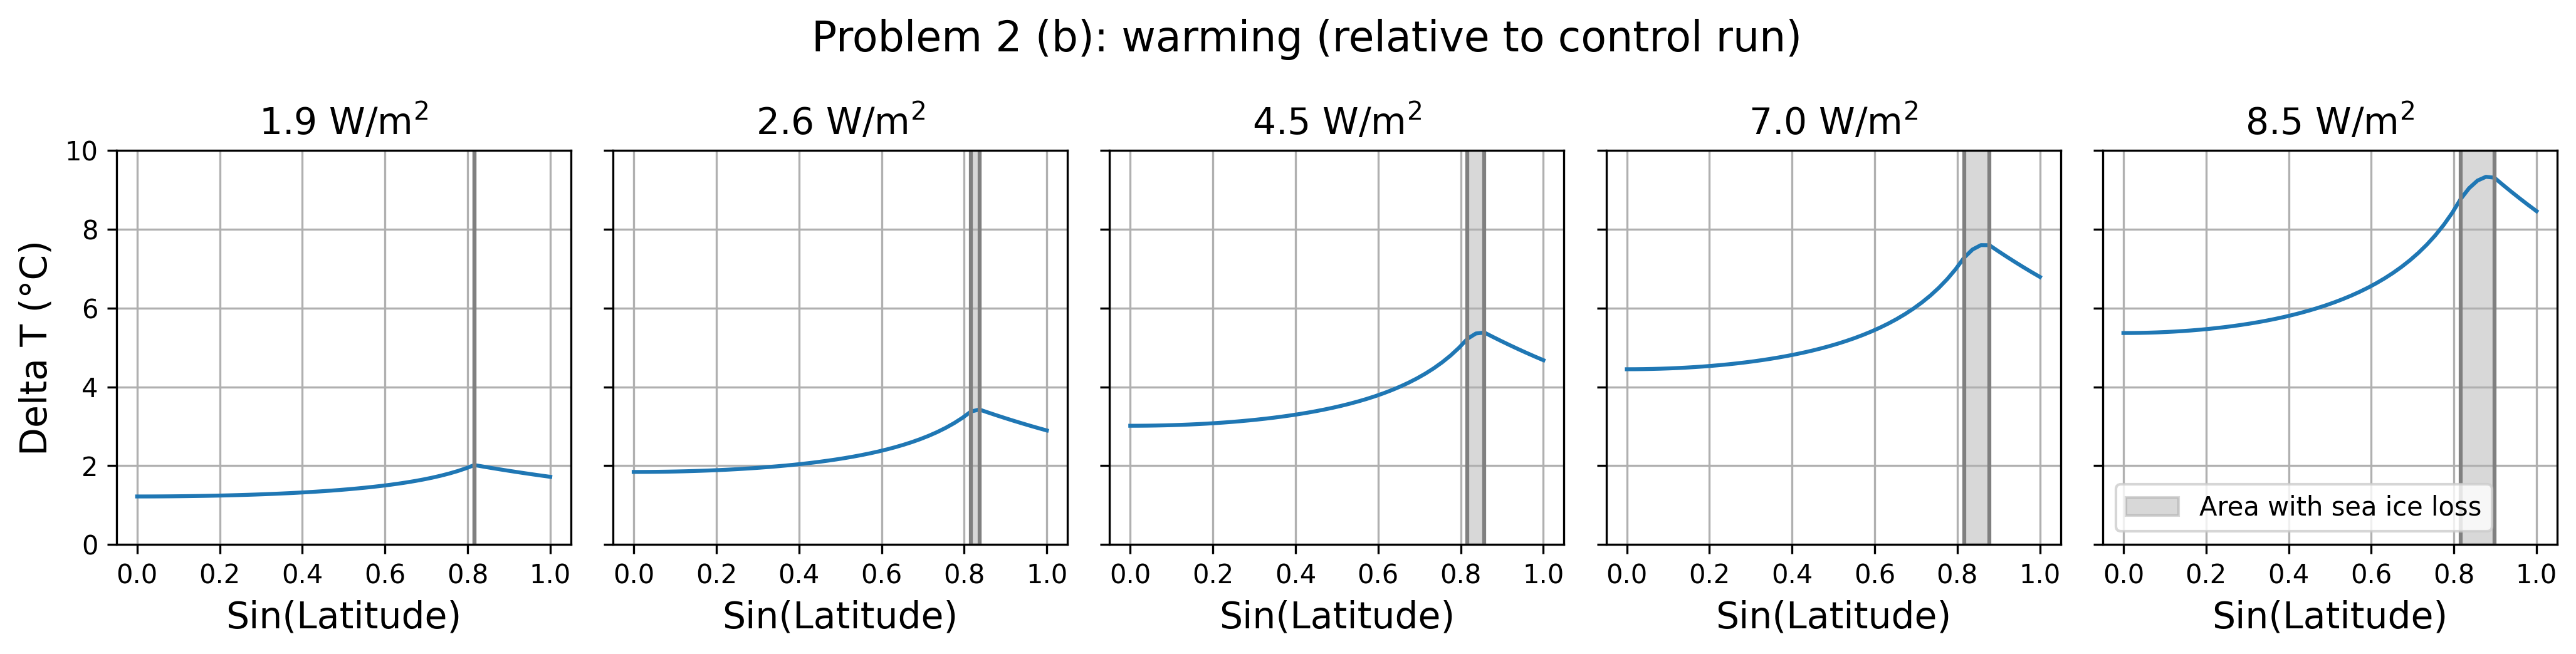

In [207]:
## Plotting
fig,ax=plt.subplots(1,5,sharex=True,sharey=True,figsize=(14,3.5),dpi=300)
fig.suptitle('Problem 2 (b): warming (relative to control run)',fontsize=fs+2)
for idx,val in enumerate(x_ic):
    ax[idx].plot(x,dTs[idx])
    ax[idx].axvline(val[0],c='grey')
    ax[idx].axvline(val[1],c='grey')
    ax[idx].axvspan(val[0],val[1],color='grey',alpha=.3,label='Area with sea ice loss')
    ax[idx].set_title(str(forcings[idx])+' W/m$^2$',fontsize=fs)
    ax[idx].grid()
    ax[idx].set_xticks(np.arange(0,1.1,.2))
    ax[idx].set_yticks(np.arange(0.,10.1,2.))
    ax[idx].set_xlabel('Sin(Latitude)',fontsize=fs)



ax[0].set_ylabel('Delta T (°C)',fontsize=fs)
ax[4].legend(loc=3)
plt.tight_layout()
plt.savefig('problem/ex2b_sol.png',dpi=300)

In [208]:
## Problem 3
# The only indication for the presence of sea ice in this very simple model is that the coalbedo is changed.
# To simulate that there is no ice present in the model, this can be turned off
# by modifying the coalbedo within the function odefunc

def odefunc(T,t):
    # previously: alpha = aw*(T>0)+ai*(T<0), i.e., if T>0 => alpha = aw (between 0.6 and 0.7) 
    # else if T<0 => alpha = ai
    # now: alpha = aw (between 0.6 and 0.7) everywhere (also where T<0)
    alpha = aw
    C = alpha*S-A+F
    Tdot = np.zeros(x.shape)
    # solve c_wdT/dt = D(1-x^2)d^
    for i in range(1,n-1):
        Tdot[i]=(D/dx**2)*(1-x[i]**2)*(T[i+1]-2*T[i]+T[i-1])-(D*x[i]/dx)*(T[i+1]-T[i-1])
        # solve c_w dT/dt = D (1-x^2) d^2 T/dx^2 - 2 x D dT/dx + C - B T [cf. WE15 eq. (2)]
        # use central difference
        Tdot[0] = D*2*(T[1]-T[0])/dx**2
        Tdot[-1] = -D*2*x[-1]*(T[-1]-T[-2])/dx
    f = (Tdot+C-B*T)/cw
    return f

F = 0.0
T0 = 10*np.ones(x.shape) # initial condition (constant temp. 10C everywhere)
time = np.linspace(0.0,30.,1000) # time span in years
T_control = odeint(odefunc,T0,time) # solve

for idx,f in enumerate(forcings):
    F = f
    t_warm = odeint(odefunc,T0,time)
    T_warms[idx] = t_warm[-1,:]
    dTs[idx]=t_warm[-1,:]-T_control[-1,:]

1.9: 0.9033009682407706
2.6: 1.2360960380282748
4.5: 2.1393969895155593
7.0: 3.3279507685400547
8.5: 4.04108312670241


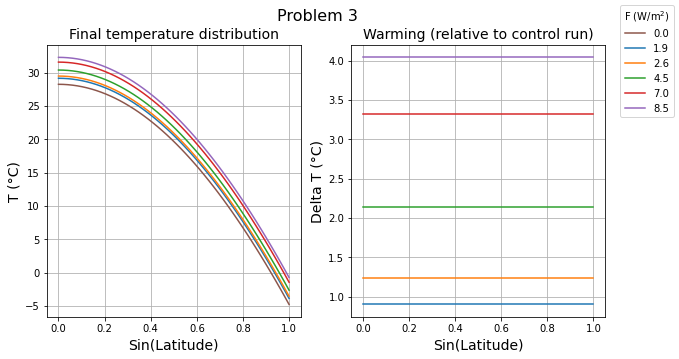

In [211]:
## Plotting
fig,ax = plt.subplots(1,2,figsize=(10,5))
for idx,val in enumerate(forcings):
    ax[0].plot(x,T_warms[idx])
    ax[1].plot(x,dTs[idx],label=str(val))
    
ax[0].plot(x,T_control[-1,:],label='0.0')
ax[0].set_xlabel('Sin(Latitude)',fontsize=fs)
ax[0].set_ylabel('T (°C)',fontsize=fs)
ax[0].grid()
ax[0].set_title('Final temperature distribution',fontsize=fs)
ax[1].set_xlabel('Sin(Latitude)',fontsize=fs)
ax[1].set_ylabel('Delta T (°C)',fontsize=fs)
ax[1].grid()
ax[1].set_title('Warming (relative to control run)',fontsize=fs)
fig.suptitle('Problem 3',fontsize=fs+2)
fig.legend(title='F (W/m$^2$)')

## calculating the mean warming for the different IPCC scenarios
for idx,val in enumerate(forcings):
    print(str(val)+': '+str(np.mean(dTs[idx])))
    
plt.savefig('problem/ex3_sol.png',dpi=300)

In [222]:
5.67*10**(-8)*(273)**4

314.94422338469997